=== Geometry and Flow ===
L = 0.300 m
Cross-sectional area A = 3.141593e-04 m^2
Q = 2.000e-08 m^3/s

=== Velocities ===
Darcy velocity q = 6.366e-05 m/s  (~0.382 cm/min)
Pore-water velocity v = 1.592e-04 m/s  (~0.955 cm/min)
Advective travel time L/v ≈ 31.42 minutes

=== Data Preview ===
   time_min  C_obs_mgL
0       1.0   2.483571
1       2.0   0.000000
2       3.0   3.238443
3       4.0   7.615149
4       5.0   0.000000

=== Fitted Parameters ===
Fitted D = 4.387e-07 m^2/s
Fitted M/A = 4.105 (mg/m^2 units)

=== Dimensionless Number ===
Peclet number Pe = 108.82



/tmp/ipykernel_30626/3403410801.py:88: RuntimeWarning: invalid value encountered in sqrt
  C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L - v * t)**2 / (4 * D * t))


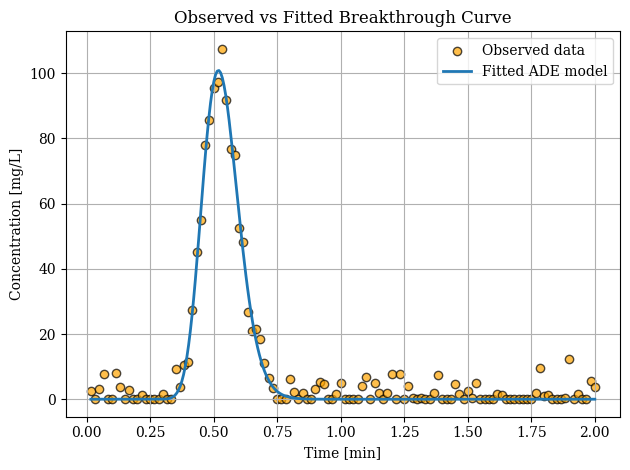

In [26]:
import numpy as np
import pandas as pd
from math import pi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------------------------------------------------------
# 1. GIVEN EXPERIMENT PARAMETERS
# ---------------------------------------------------------------------

# Column geometry
L_cm = 30.0                         # column length [cm]
d_cm = 2.0                          # column diameter [cm]
theta = 0.40                        # water content (saturated, dimensionless)

# Flow rate
Q_cm3_min = 1.2                     # volumetric flow rate [cm^3/min]

# Convert to SI units
L = L_cm / 100.0                    # length [m]
r_m = (d_cm / 2.0) / 100.0          # radius [m]
A = pi * r_m**2                     # cross-sectional area [m^2]

# 1 cm^3 = 1e-6 m^3, 1 min = 60 s
Q_m3_s = Q_cm3_min * 1e-6 / 60.0    # [m^3/s]

print("=== Geometry and Flow ===")
print(f"L = {L:.3f} m")
print(f"Cross-sectional area A = {A:.6e} m^2")
print(f"Q = {Q_m3_s:.3e} m^3/s")

# ---------------------------------------------------------------------
# 2. Compute Darcy velocity q and pore-water velocity v
# ---------------------------------------------------------------------

# Darcy velocity q = Q/A
q = Q_m3_s / A                 # [m/s]

# Pore-water (seepage) velocity v = q / theta
v = q / theta                  # [m/s]

# Also show in cm/min for intuition
q_cm_min = q * 100.0 * 60.0    # [cm/min]
v_cm_min = v * 100.0 * 60.0    # [cm/min]

print("\n=== Velocities ===")
print(f"Darcy velocity q = {q:.3e} m/s  (~{q_cm_min:.3f} cm/min)")
print(f"Pore-water velocity v = {v:.3e} m/s  (~{v_cm_min:.3f} cm/min)")

# Characteristic advective travel time: t_adv = L / v
t_adv_s = L / v                 # [s]
t_adv_min = t_adv_s / 60.0      # [min]
print(f"Advective travel time L/v ≈ {t_adv_min:.2f} minutes")


# ---------------------------------------------------------------------
# 3. Define ADE pulse solution at x = L
# ---------------------------------------------------------------------
df = pd.read_csv("breakthrough_data.csv")

print("\n=== Data Preview ===")
print(df.head())

# Extract data arrays
t_min = df["time_min"].values     # time in minutes
C_obs = df["C_obs_mgL"].values    # observed concentration [mg/L]

# Convert time to seconds for the model
t_s = t_min * 60.0

def C_model(t, D, M_over_A):
    """
    ADE pulse solution at x = L:
    C(L,t) = (M/A) / (theta * sqrt(4*pi*D*t)) * exp( - (L - v*t)^2 / (4*D*t) )

    Parameters
    ----------
    t        : array - Time [s]
    D        : float - Dispersion coefficient [m^2/s]
    M_over_A : float - Mass per area [mg/m^2]-type units, consistent with data.

    Returns
    -------
    C        : array - Modeled concentration [mg/L].
    """
    t = np.asarray(t)
    # Avoid divide-by-zero (curve_fit will not evaluate exactly at t=0 if we mask)
    C = (M_over_A / (theta * np.sqrt(4 * pi * D * t))) * np.exp(- (L - v * t)**2 / (4 * D * t))
    return C

# ---------------------------------------------------------------------
# 4. Fit D and M/A using curve_fit
# ---------------------------------------------------------------------

# Exclude any t = 0 to avoid numerical issues
mask = t_s > 0
t_fit = t_s[mask]
C_fit_obs = C_obs[mask]

# Initial guesses
D_initial = 1e-6      # [m^2/s] rough guess
MA_initial = 1.0      # [mg/m^2] rough guess
p0 = [D_initial, MA_initial]

# Perform nonlinear least squares fit
popt, pcov = curve_fit(C_model, t_fit, C_fit_obs, p0=p0, maxfev=10000)
D_fit, M_over_A_fit = popt

print("\n=== Fitted Parameters ===")
print(f"Fitted D = {D_fit:.3e} m^2/s")
print(f"Fitted M/A = {M_over_A_fit:.3f} (mg/m^2 units)")

# ---------------------------------------------------------------------
# 5. Compute Peclet number Pe = v * L / D
# ---------------------------------------------------------------------

Pe = v * L / D_fit
print("\n=== Dimensionless Number ===")
print(f"Peclet number Pe = {Pe:.2f}\n")

# ---------------------------------------------------------------------
# 6. Plot observed vs fitted breakthrough curve
# ---------------------------------------------------------------------

t_plot_s = np.linspace(t_s.min(), t_s.max(), 300)
t_plot_min = t_plot_s / 60.0
C_model_plot = C_model(t_plot_s, D_fit, M_over_A_fit)

plt.figure()
plt.scatter(t_min/60, C_obs, label="Observed data", c="orange", edgecolors='black', alpha=0.7)
plt.plot(t_plot_min/60, C_model_plot, label="Fitted ADE model", linewidth=2)
plt.xlabel("Time [min]")
plt.ylabel("Concentration [mg/L]")
plt.title("Observed vs Fitted Breakthrough Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
